In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt','r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [7]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1  for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [122]:
# building the dataset

block_size = 3 # context len: How many chars do we take to predict the next one?
X,Y = [],[]
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] #crop and append
X = torch.tensor(X)
Y= torch.tensor(Y)

In [123]:
X.shape , X.dtype , Y.shape , Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [11]:
C = torch.randn((27,2))
C

tensor([[ 0.8959,  1.2131],
        [-0.9136, -0.3163],
        [-0.5304, -0.8201],
        [ 1.2971,  0.4058],
        [ 0.6801, -0.9056],
        [ 0.8102, -0.3732],
        [-0.5047,  0.2449],
        [ 1.5613,  0.0891],
        [-1.5376,  1.1422],
        [ 0.6614,  2.1472],
        [ 0.5323,  0.5560],
        [-0.3433,  0.1355],
        [ 1.1247,  0.9411],
        [ 0.5037, -1.9179],
        [-0.1829, -1.5861],
        [-0.3244, -0.9052],
        [-0.3437, -0.2625],
        [-0.8294,  2.8906],
        [ 0.4499,  0.9340],
        [ 0.4411, -0.8830],
        [ 1.1799,  1.0908],
        [ 1.9024, -1.1383],
        [-0.5126, -0.8265],
        [-0.8112, -1.2546],
        [-1.4400,  0.0164],
        [-0.1681, -0.2786],
        [-0.4309, -1.4379]])

For an example 5 we can directly take the 5th value like this

In [12]:
C[5]

tensor([ 0.8102, -0.3732])

Or we can do the same using one-hot encoded value of the tensor 5 in a num class of 27 by ensuring the dtypes are same as torch one-hot encodes in int-64(long)

In [13]:
F.one_hot(torch.tensor(5),num_classes=27).float() @ C

tensor([ 0.8102, -0.3732])

now
for X or 2d vector 

In [20]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [17]:
X[13,2]

tensor(1)

In [18]:
C[X][13,2]

tensor([-0.9136, -0.3163])

In [19]:
C[1]

tensor([-0.9136, -0.3163])

In [21]:
w1 = torch.randn((6,100))
b1 = torch.randn(100)

In [23]:
# emb @ w1 + b1
# mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [31]:
# for block size 3 
# torch.cat([emb [: , 0 , :] , emb [: , 1, :] , emb [: , 2 , :]],1).shape

In [30]:
# generalized approach 
# but inefficient
#torch.cat(torch.unbind(emb, 1),1).shape

torch.Size([32, 6])

In [43]:
# emb.shape

In [42]:
#emb.view(32,6) == torch.cat(torch.unbind(emb, 1),1)

#### while using -1 for .view pytorch infers what the rows size must be for it to be correct with the given number of columns i.e. 6

In [44]:
h = torch.tanh(emb.view(-1,6) @ w1 + b1)

In [45]:
h

tensor([[-0.6238,  0.8664,  0.0609,  ...,  0.9905, -0.9632,  0.5935],
        [-0.9820,  0.2700,  0.1812,  ...,  0.9491,  0.6605, -0.0780],
        [-0.8798, -0.9908,  0.5574,  ..., -0.7261,  0.9984,  0.8767],
        ...,
        [ 0.9294, -0.9996,  0.0515,  ..., -0.5730, -0.9987,  0.9398],
        [ 0.5700,  0.9992, -0.9681,  ...,  0.9996, -1.0000, -0.8574],
        [-0.9255, -0.9624,  0.3631,  ...,  0.6286, -0.1404, -0.9892]])

In [46]:
w2 = torch.randn((100 , 27))
b2 = torch.randn(27)

In [47]:
logits =  h @ w2 + b2

In [48]:
logits.shape

torch.Size([32, 27])

In [49]:
counts = logits.exp()

In [50]:
prob = counts / counts.sum(1,keepdims = True)

In [51]:
prob.shape

torch.Size([32, 27])

In [57]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(16.7670)

In [58]:
# ------------ code more arranged -------------------

In [174]:
X.shape , Y.shape # the dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [175]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27,2),generator = g)
W1 = torch.randn((6,100),generator =g)
b1 = torch.randn(100,generator =g)
W2 = torch.randn((100,27),generator =g)
b2 = torch.randn(27,generator =g)
parameters = [C,W1,b1,W2,b2]

In [176]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [177]:
for p in parameters:
    p.requires_grad = True

In [178]:
lre =  torch.linspace(-3, 0,1000)
lrs = 10 ** lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [180]:
lri =[]
lossi=[]
for i in range(1000):
    #construct a minibatch
    ix = torch.randint(0,X.shape[0],(32,))
    
    #forward pass
    emb = C[X[ix]] #(32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(32,100)
    logits =  h @ W2 + b2 #(32,27)
    loss = F.cross_entropy(logits,Y[ix])
    print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * (p.grad)
        
    #track stats
    lri.append(lr)
    lossi.append(loss.item())
#print(loss.item())

17.91893768310547
20.63041877746582
21.718124389648438
18.813034057617188
17.672698974609375
19.153711318969727
19.96426010131836
16.50014305114746
18.556915283203125
20.313121795654297
17.214590072631836
19.456756591796875
18.897960662841797
17.503143310546875
18.993534088134766
17.992286682128906
17.362857818603516
17.4293270111084
21.861679077148438
18.870380401611328
18.084228515625
18.259952545166016
19.10805320739746
16.763408660888672
22.810461044311523
14.74560832977295
18.740947723388672
17.85880470275879
18.05872344970703
17.821575164794922
16.53266716003418
17.99235725402832
18.395336151123047
19.440256118774414
18.71743392944336
20.024934768676758
16.253442764282227
17.496204376220703
20.591007232666016
19.800674438476562
19.85674476623535
16.800817489624023
20.124649047851562
16.9986572265625
18.020950317382812
18.256649017333984
18.946048736572266
18.122230529785156
18.25190544128418
18.851829528808594
16.500473022460938
19.07237434387207
17.469419479370117
17.51596450805

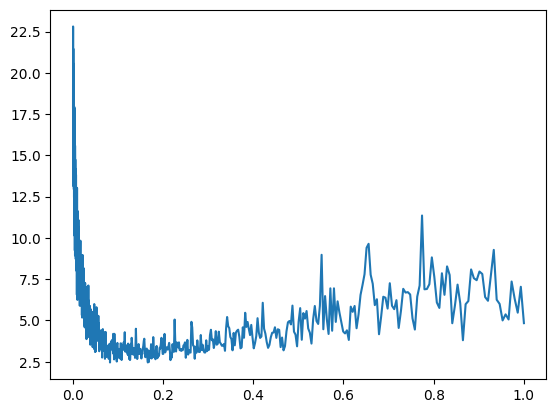

In [181]:
plt.plot(lri,lossi)

In [160]:
emb = C[X] #(32,3,2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(32,100)
logits =  h @ W2 + b2 #(32,27)
loss = F.cross_entropy(logits,Y)
loss

tensor(2.5343, grad_fn=<NllLossBackward0>)

In [ ]:
#49.48